## Single objective optimization

Here we will do a basic single-objective optimization. This will be done using a Gaussian Process to map input parameters to the objective, and make subsequent recommendations for experiments.

In [8]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

from olympus import Surface
from olympus.campaigns import ParameterSpace, Campaign
from olympus.objects import ParameterContinuous
from atlas.planners.gp.planner import GPPlanner

sns.set(style='ticks', context='notebook', font_scale=1.2)
from cmcrameri import cm


In [14]:
## helper functions
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])

cmap = cm.nuuk

def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap=cmap):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_constr_surface(surface, ax=None, N=100):
    ''' Plot the Olympus surface, N controls the number of points to sample
    '''
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap=cmap) #'golem'
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)

def plot_constr_surface_with_scatter(ax, surface, data, repeat=0):

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    plot_constr_surface(surface, ax=ax, N=100)

    repeat = 0
    X = data[repeat].loc[:, ['x0', 'x1']]
    #mask = surface.eval_constr(X.to_numpy())
    mask = np.array([True for _ in range(len(X))])
    X_feas = X[mask]
    X_infs = X[~mask]

    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)

## Theoretical optimization space

Here, we will start with a simple optimization surface, the Branin-Hoo surface. The goal is to find the minima of the surface by varying 2 input $(x_0, x_1)$.

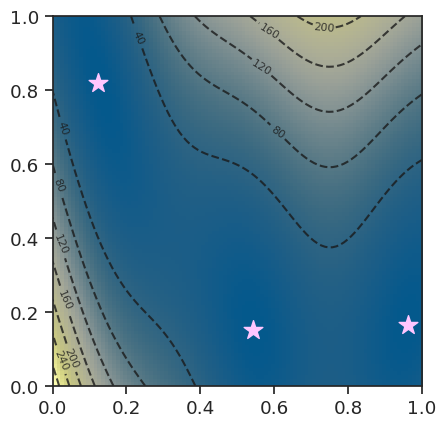

In [10]:
# initialize the problem space, and visualize it
surface = Surface(kind='Branin')

fig, axes = plt.subplots(1,1)
plot_constr_surface(surface, axes)

In [16]:
# Set some initial parameters
BUDGET = 30                 # how many measurements are allowed
NUM_INIT_DESIGN = 5         # how many initial measurements

In [ ]:
# start a campaign, which keeps track of the measurements and targets
campaign = Campaign()
campaign.set_param_space(surface.param_space)

planner = GPPlanner(goal='minimize', num_init_design=NUM_INIT_DESIGN) # instantiate Atlas planner
planner.set_param_space(surface.param_space)


while len(campaign.observations.get_values()) < BUDGET:
    samples = planner.recommend(campaign.observations) # ask planner for batch of parameters
    for sample in samples:
        measurement = surface.run(sample) # measure Branin-Hoo function
        campaign.add_observation(sample, measurement) # tell planner about most recent observation

In [23]:
# to access the measurements, we can gather the results from the campaign
params = campaign.get_params()      # the parameters
objs = campaign.get_values()        # the objective value

# put into a pandas dataframe for convenience
df_gp = pd.DataFrame({'x0': params[:, 0].flatten(), 'x1': params[:, 1].flatten(), 'obj': objs[:].flatten()})
df_gp.head()

,x0,x1,obj
0,0.482116,0.123662,5.634700
1,0.274550,0.539074,16.444189
2,0.451501,0.455776,18.650442
3,0.326579,0.457993,20.053193
4,0.223969,0.944575,36.476601


We can also look at the cumulative best value as a function of measurements made. As a baseline, we can also do random sampling strategy, to see comparatively how the `GPPlanner` reduces the number of measurements are required.

In [ ]:
# run another campaign, but this time, the initial design will be the entire budget
# the initial design uses a random uniform sampling strategy
campaign = Campaign()
campaign.set_param_space(surface.param_space)

planner = GPPlanner(goal='minimize', num_init_design=BUDGET) # instantiate Atlas planner
planner.set_param_space(surface.param_space)


while len(campaign.observations.get_values()) < BUDGET:
    samples = planner.recommend(campaign.observations) # ask planner for batch of parameters
    for sample in samples:
        measurement = surface.run(sample) # measure Branin-Hoo function
        campaign.add_observation(sample, measurement) # tell planner about most recent observation

# to access the measurements, we can gather the results from the campaign
params = campaign.get_params()      # the parameters
objs = campaign.get_values()        # the objective value

# put into a pandas dataframe for convenience
df_random = pd.DataFrame({'x0': params[:, 0].flatten(), 'x1': params[:, 1].flatten(), 'obj': objs[:].flatten()})

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/30)

ATLAS [INFO] Generating 1 initial design points (batch 2/30)

ATLAS [INFO] Generating 1 initial design points (batch 3/30)

ATLAS [INFO] Generating 1 initial design points (batch 4/30)

ATLAS [INFO] Generating 1 initial design points (batch 5/30)

ATLAS [INFO] Generating 1 initial design points (batch 6/30)

ATLAS [INFO] Generating 1 initial design points (batch 7/30)

ATLAS [INFO] Generating 1 initial design points (batch 8/30)

ATLAS [INFO] Generating 1 initial design points (batch 9/30)

ATLAS [INFO] Generating 1 initial design points (batch 10/30)

ATLAS [INFO] Generating 1 initial design points (batch 11/30)

ATLAS [INFO] Generating 1 initial design points (batch 12/30)

ATLAS [INFO] Generating 1 initial design points (batch 13/30)

ATLAS [INFO] Generating 1 initial design points (batch 14/30)

ATLAS [INFO] Generating 1 initial design points (batch 15/30)

ATLAS [INFO] Generating 1 initial design points (batch 16/30)

ATLAS [INFO] Generating 1 initial design points (batch 17/30)

ATLAS [INFO] Generating 1 initial design points (batch 18/30)

ATLAS [INFO] Generating 1 initial design points (batch 19/30)

ATLAS [INFO] Generating 1 initial design points (batch 20/30)

ATLAS [INFO] Generating 1 initial design points (batch 21/30)

ATLAS [INFO] Generating 1 initial design points (batch 22/30)

ATLAS [INFO] Generating 1 initial design points (batch 23/30)

ATLAS [INFO] Generating 1 initial design points (batch 24/30)

ATLAS [INFO] Generating 1 initial design points (batch 25/30)

ATLAS [INFO] Generating 1 initial design points (batch 26/30)

ATLAS [INFO] Generating 1 initial design points (batch 27/30)

ATLAS [INFO] Generating 1 initial design points (batch 28/30)

ATLAS [INFO] Generating 1 initial design points (batch 29/30)

ATLAS [INFO] Generating 1 initial design points (batch 30/30)

,x0,x1,obj
0,0.873209,0.433764,31.916190
1,0.881381,0.637830,69.296376
2,0.870583,0.097367,8.058218
3,0.122221,0.703558,3.576440
4,0.506949,0.500807,24.606605


Finally, when we plot the values, we can see that the GPPlanners are more focused in measurements, clustering around the minima of the Branin-Hoo function in this parameter space. We also see the Random sampling method does not achieve as low of an objective as the GPPlanners, and the estimates are more homogeneous distributed in the parameter space.

Text(0.5, 0, 'Evaluations')

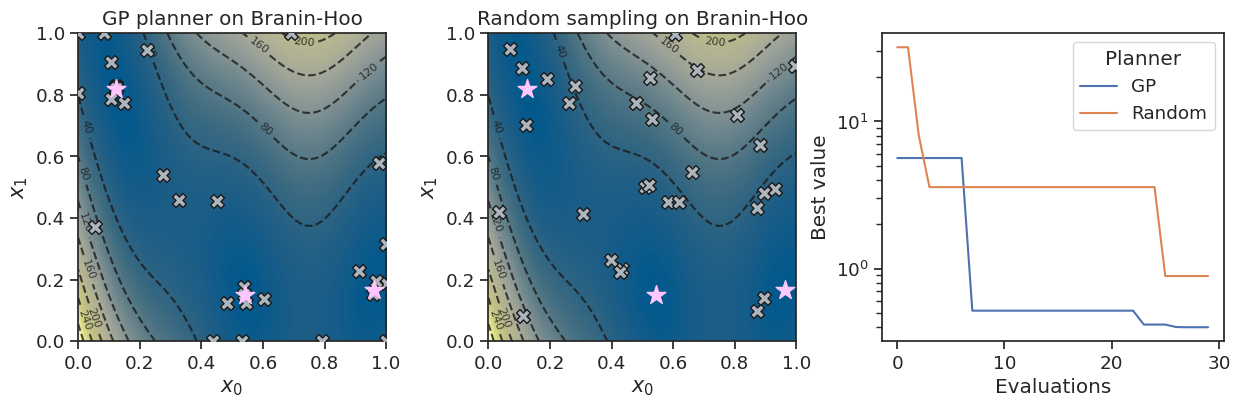

In [35]:
fig, axes = plt.subplots(1,3, figsize=(15,4))

# plot GP planner
plot_constr_surface_with_scatter(axes[0], surface, [df_gp], repeat=0)
axes[0].set_title('GP planner on Branin-Hoo')
axes[0].set_xlabel(r'$x_0$', fontsize=15)
axes[0].set_ylabel(r'$x_1$', fontsize=15)

# plot the random sampling
plot_constr_surface_with_scatter(axes[1], surface, [df_random], repeat=0)
axes[1].set_title('Random sampling on Branin-Hoo')
axes[1].set_xlabel(r'$x_0$', fontsize=15)
axes[1].set_ylabel(r'$x_1$', fontsize=15)

# process the dataframes
df_gp['Planner'] = 'GP'
df_gp['Best value'] = df_gp['obj'].cummin()
df_random['Planner'] = 'Random'
df_random['Best value'] = df_random['obj'].cummin()
all_df = pd.concat([df_gp, df_random])

# plot the best trace
sns.lineplot(data=all_df, x=all_df.index, y='Best value', hue='Planner', ax=axes[2])
axes[2].set_yscale('log')
axes[2].set_xlabel('Evaluations')

